# This script identifies LG analogues in the halo catalogue and extracts the merger tree data from the tree file, in preparation for plotting.

### Running this script requires the Uchuu z=0 halo catalog and merger tree files, which are available at skiesanduniverses.org.

Note that some steps take a lot of time (mostly due to reading files from disk). If you don't want to rerun them each time, skip those cells. This script is designed to save intermediate results to disk and read them from disk.

### Define path for local modules

This will depend on your particular environment and will not be necessary if you have all packages that are imported below in your standard python path.

In [1]:
import sys
print(sys.path)

sys.path.append('C:/Users/equel/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0/LocalCache/local-packages/Python313/site-packages')

print("now:", sys.path)


['/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python310.zip', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/lib-dynload', '', '/users/erwannqu/.local/lib/python3.10/site-packages', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages']
now: ['/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python310.zip', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/lib-dynload', '', '/users/erwannqu/.local/lib/python3.10/site-packages', '/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages', 'C:/Users/equel/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0/LocalCache/local-packages/Python313/site-packages']


### Imports

In [ ]:
import numpy as np
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import norm


from scipy.signal import savgol_filter   

import random
import math

from scipy import optimize
from scipy.optimize import fsolve
from scipy import spatial

import heapq

import timeit
import glob
from tqdm import tqdm

import os
import pickle
import psutil

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

from itertools import zip_longest

from collections import defaultdict
from time import perf_counter
import gc
import shelve
from multiprocessing import Pool

import shutil


print ("loaded modules")

loaded modules


### Parameters

In [3]:
# File for the z=0 LG data.
LG_data_file = 'no_LG_data.npz'

LG_tree_file = 'new_MiniUchu_treedata_set.npz'

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3, Tcmb0=2.725)

hubble = .6774

G = 4300700 # for M in units of 10^12
max_residual = 1e-4 # for the TA solution
bounds = [(1e-2, 2*np.pi)] # bounds on eta for slsqp solver

boxSize = 2000. / hubble * 1000. 

m_MW_min = 0.7e12  # minimum mass for the MW haloes at z=0
m_MW_max = 1.5e12 # maximum mass for the MW haloes at z=0
m_M31_min = 1.0e12 # minimum mass for the M31 haloes at z=0
m_M31_max = 2.0e12 # maximum mass for the M31 haloes at z=0


snapshots = np.array([50,45,40,30,20,15,12])
particle_index = np.arange(0,len(snapshots))   # for indexing the particle data
tree_index = 50 - snapshots                    # for indexing the tree data

fine_index = np.arange(0,max(tree_index)+1)

print ("tree indices:", tree_index, "particle indices:", particle_index)
print ("fine index:", fine_index)

# ages to display
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# redshifts to display 
label_redshifts = np.array([4,3,2,1,0.5,0.2,0])
label_redshifts_str = ["4","3","2","1","0.5","0.2","0"]
label_scales = 1 / (label_redshifts + 1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


m_min_gravity = 0.2e12 # consider perturbers above 2 x 10^11

N_volumes = 1 # For Mini-Uchuu, there is only one file

basePath = '/scratch/project_2010958/uchuu_catalogues/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/RockstarExtendedM200c1e11/halodir_050/'

tree indices: [ 0  5 10 20 30 35 38] particle indices: [0 1 2 3 4 5 6]
fine index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


### Custom Functions

Useless in this project

In [4]:
# We solve the eta equation, and then calculate a, M_TA and e.

# solve to obtain eta from t, r, vr, vt
def EtaEquation(eta, *data):
    r, vr, vt, t = data

    epsilon = 1e-10

    c = vt**2 / vr**2
    eqn = t * vr / r - np.sin(eta) * ( eta * (c * np.sin(eta)*np.sin(eta) + 1)**.5 - np.sin(eta)) / ((np.cos(eta) - (c * np.sin(eta) * np.sin(eta) + 1)**.5)**2+epsilon)
    
    eqn = np.abs(eqn)
    
    return eqn


# The full TA equations, only used to check results
def TAequations(variables, *data):
    
    r, vr, vt, t = data[0]
    G = 4300700 # for M in units of 10^12
    
    a, e, eta, M = variables
    
    a = a * 1000 # to have a in Mpc
    
    eqn_1 = (a * (1. - e * np.cos(eta) ) - r) 
    eqn_2 = ( (a**3 / (G * M) )**.5 * (eta - e * np.sin(eta) ) - t ) 
    eqn_3 = ((G * M) / a)**.5 * e * np.sin(eta)  / (1. - e * np.cos (eta) + 1.e-12) - vr
    eqn_4 = ((G * M) / a)**.5 * (1. - e**2)**.5 / (1. - e * np.cos(eta) + 1.e-12) - vt
    return [eqn_1, eqn_2, eqn_3, eqn_4]


def evalTA(p, *data): # evaluate the general TA given the parameters and the data
    return abs(sum(np.array(TAequations(p, data))**2))




### Read the Uchuu scale factors

In [5]:
'''f = open('Uchuu_redshift_scalefactors.txt', 'r')

lines = f.readlines()
scale = []
                  
for line in lines:
    columns = line.split()
    scale.append(float(columns[2]))

scale = np.flip(scale)
print ("scalefactors:", scale)'''

'f = open(\'Uchuu_redshift_scalefactors.txt\', \'r\')\n\nlines = f.readlines()\nscale = []\n                  \nfor line in lines:\n    columns = line.split()\n    scale.append(float(columns[2]))\n\nscale = np.flip(scale)\nprint ("scalefactors:", scale)'

In [6]:
scale = [0.999887, 0.977848, 0.956412, 0.914941, 0.87523, 0.837539, 0.801034, 0.766456,
 0.733135, 0.701575, 0.671151, 0.642035, 0.614153, 0.587537, 0.562099, 0.537713,
 0.514356, 0.49213, 0.470773, 0.450389, 0.430727, 0.412155, 0.394333, 0.377182,
 0.360886, 0.34528, 0.330255, 0.315864, 0.30214, 0.289175, 0.276536, 0.264684,
 0.253086, 0.242223, 0.231799, 0.216898, 0.202878, 0.189856, 0.177649, 0.162519,
 0.148772, 0.136158, 0.124496, 0.113967, 0.104325, 0.095413, 0.087363, 0.079949,
 0.073131, 0.066964]

scale = np.array(scale)

### Read the halo catalogue.
#### This is done in addition to the tree file, as it contains the tidal information. 

In [7]:
# select all the files
files = glob.glob(basePath + 'halolist_z0p00_m200c1e11_*.h5')
files = np.sort(files)
N_volumes = len(files)
print(f"{N_volumes} files found")

# Lists to concatenate
all_x, all_y, all_z = [], [], []
all_vx, all_vy, all_vz = [], [], []
all_m200 = []
all_pid, all_ID, all_TidalID = [], [], []

# Looping on all the files
print("Reading files...")
for i in tqdm(range(N_volumes)):
    with h5py.File(files[i], 'r') as hf:
        all_x.append(np.array(hf['x']) / hubble * 1000.)
        all_y.append(np.array(hf['y']) / hubble * 1000.)
        all_z.append(np.array(hf['z']) / hubble * 1000.)

        all_vx.append(np.array(hf['vx']))
        all_vy.append(np.array(hf['vy']))
        all_vz.append(np.array(hf['vz']))

        all_m200.append(np.array(hf['M200c']) / hubble)

        all_pid.append(np.array(hf['pid']))
        all_ID.append(np.array(hf['id']))
        all_TidalID.append(np.array(hf['Tidal_ID']))

        hf.close()
        
print("Concatenation ...")

# Concatenation in 1D array 
x = np.concatenate(all_x)
y = np.concatenate(all_y)
z = np.concatenate(all_z)

vx = np.concatenate(all_vx)
vy = np.concatenate(all_vy)
vz = np.concatenate(all_vz)

pos = np.array([x,y,z]).T
vel = np.array([vx,vy,vz]).T

m200 = np.concatenate(all_m200)

pid = np.concatenate(all_pid)
ID = np.concatenate(all_ID)
TidalID = np.concatenate(all_TidalID)

print("All files red.")
print(f"Total number of halos : {len(x):_}".replace('_', ' '))

100 files found
Reading files...


100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


Concatenation ...
All files red.
Total number of halos : 264 675 366


### Find pairs in the halo catalogue

In [8]:
print("ID > 0", len(TidalID[ID > 0]))
print("TidalID > 0", len(TidalID[TidalID > 0]))
print("TidalID < 0", len(TidalID[TidalID < 0]))


# Select subhalo samples

totNum = len(m200)

print("Total number of halos:", totNum)

# Select MW halo
selectIndex_MW = np.full(totNum, False)
selectIndex_MW[m200 > m_MW_min] = True
selectIndex_MW[m200 > m_MW_max] = False

selectNum_MW = len(m200[selectIndex_MW])

print('Number of selected MW halos:', selectNum_MW)

print('Minimum mass:', min(m200[selectIndex_MW]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex_MW]) / 1.e12, ' x 10^12' )

# Select M31 halo
selectIndex_M31 = np.full(totNum, False)
selectIndex_M31[m200 > m_M31_min] = True
selectIndex_M31[m200 > m_M31_max] = False

selectNum = len(m200[selectIndex_M31])

print('Number of selected M31 halos:', selectNum)

print('Minimum mass:', min(m200[selectIndex_M31]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex_M31]) / 1.e12, ' x 10^12' )


M_MW = []
M_M31 = []

ID_MW = []
ID_M31 = []

M_MW = np.array(list(m200[selectIndex_MW]))
M_M31 = np.array(list(m200[selectIndex_M31]))

ID_MW = np.array(list(ID[selectIndex_MW]))
ID_M31 = np.array(list(ID[selectIndex_M31]))


ID > 0 264675366
TidalID > 0 263539273
TidalID < 0 1136093
Total number of halos: 264675366
Number of selected MW halos: 32872428
Minimum mass: 0.7004723944493653  x 10^12
Maximum mass: 1.4998523767345733  x 10^12
Number of selected M31 halos: 22247611
Minimum mass: 1.000265721877768  x 10^12
Maximum mass: 2.0  x 10^12


### Save z=0 data to file

In [9]:
print ("file:", LG_data_file)

file: no_LG_data.npz


In [10]:
np.savez(LG_data_file, allow_pickle = True, ID_MW=ID_MW, ID_M31=ID_M31, M_MW = M_MW, M_M31 = M_M31)

print ('done writing file')

done writing file


### Read the LG data file back

In [21]:
data = np.load(LG_data_file)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

ID_MW = data['ID_MW']
ID_M31 = data['ID_M31']

M_MW = data['M_MW']
M_M31 = data['M_M31']

print ('done reading LG file')

['allow_pickle', 'ID_MW', 'ID_M31', 'M_MW', 'M_M31']
done reading LG file


In [7]:
print(len(ID_MW))

32872428


#### We select random elements il both lists to have a similar size + quicker computation

In [8]:
n = 7000

indices_MW = random.sample(range(len(ID_MW)), n)
indices_M31 = random.sample(range(len(ID_M31)), n)

ID_MW = [ID_MW[i] for i in indices_MW]
ID_M31 = [ID_M31[i] for i in indices_M31]

M_MW = [M_MW[i] for i in indices_MW]
M_M31 = [M_M31[i] for i in indices_M31]

In [9]:
print(len(ID_MW))

7000


In [10]:
file_path = '/scratch/project_2010958/uchuu_mergertrees/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_0.h5'

with h5py.File(file_path, 'r') as f:
    print("Content keys of the .h5 files :")
    for key in f.keys():
        print(f"  - {key} : {type(f[key])}")
        
        if isinstance(f[key], h5py.Dataset):
            print(f"    -> shape: {f[key].shape}, dtype: {f[key].dtype}")
        elif isinstance(f[key], h5py.Group):
            print(f"    -> group countaining {len(f[key])} sub-elements")

    forests_group = f['Forests']
    print(f"Ket : {list(forests_group.keys())}")

Content keys of the .h5 files :
  - ForestInfo : <class 'h5py._hl.dataset.Dataset'>
    -> shape: (1530564,), dtype: [('ForestID', '<i8'), ('ForestHalosOffset', '<i8'), ('ForestNhalos', '<i8'), ('ForestNtrees', '<i8')]
  - Forests : <class 'h5py._hl.group.Group'>
    -> group countaining 67 sub-elements
  - TreeInfo : <class 'h5py._hl.dataset.Dataset'>
    -> shape: (1961530,), dtype: [('ForestID', '<i8'), ('TreeRootID', '<i8'), ('TreeHalosOffset', '<i8'), ('TreeNhalos', '<i8'), ('Input_Filename', 'S1024'), ('Input_FileDateStamp', '<f8'), ('Input_TreeByteOffset', '<i8'), ('Input_TreeNbytes', '<i8')]
  - simulation_params : <class 'h5py._hl.group.Group'>
    -> group countaining 0 sub-elements
Ket : ['A_x', 'A_x_500c', 'A_y', 'A_y_500c', 'A_z', 'A_z_500c', 'Breadth_first_ID', 'Depth_first_ID', 'Descendant', 'FirstHaloInFOFgroup', 'FirstProgenitor', 'FofID', 'Halfmass_Radius', 'Jx', 'Jy', 'Jz', 'Last_mainleaf_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'M200b', 'M200c', 'M2500c', 'M

### Load, select, and save the tree files.

#### First, make an halo index file to link a halo ID to its position in the tree files

In [ ]:
# PARAMETERS
treefiles = [f"/scratch/project_2010958/uchuu_catalogues/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/MergerTree/mergertree_{i}.h5" for i in range(2000)]
output_file_template = "trees_no_LG_{}.h5"
desc_map_file_template = "desc_map_shelve_{}.db"
LG_data_file = "no_LG_data.npz"
fields = ['id', 'desc_id', 'M200c', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Snap_idx']
chunk_size = 1_000_000
num_process = 40

In [ ]:
# Print the memory used
def print_mem_usage(tag=""):
    mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2   # takes the used memory in MB
    print(f"[{tag}] Used memory : {mem:.2f} MB")                    # print


# Free the memory used for objects given in arguments
def clean_mem(*args):
    for arg in args:
        del arg     # delete each object
    gc.collect()    # memory cleaning


def make_desc_index(file_id, treefile, halo_ids_to_follow, desc_map_file):
    '''
    Create a desc index => for each halo ID, look to see which halo has its desc_id = ID

    Parameters :
        file_id (int) : ID of the file being read (used to locate the halo)
        treefile (str) : Path of the .h5 containing the merger tree data
        halo_ids_to_follow (set of int) : Set of halo IDs selected to look for progenitors
        desc_map_file (str) : Path to the shelve file where the index will be saved

    Returns :
        a shelve dictionary saved on disk, for example :
            {"123456789" : [(0,1200,48), (0,1389,47), (1,69456,48)],  # the halo 123456789 has 3 progenitors for example file 0, No.1200, snap 48
             "987654321" : [(1,401,32)],                              # the halo 987654321 has 1 progenitor
             ...
            }
    '''
    to_follow = set(halo_ids_to_follow)                    # IDs to follow
    seen = set()                                           # avoid duplications
    if os.path.exists(desc_map_file):
        os.remove(desc_map_file)                           # we delete the given file if it already exists

    with shelve.open(desc_map_file) as desc_map:           # open a "persistent dictionary"
        with h5py.File(treefile, 'r') as f:
            group = f['Forests']
            total = len(group['id'])
            
            for start in range(0, total, chunk_size):      # we're cutting the reading into chunks
                end = min(start + chunk_size, total)
                ids = group['id'][start:end]
                desc_ids = group['desc_id'][start:end]
                snaps = group['Snap_idx'][start:end]

                for i in range(end - start):              # go through the halos of a chunk to make the descendants index
                    this_id = int(ids[i])
                    desc_id = int(desc_ids[i])
                    if this_id in to_follow or desc_id in to_follow:
                        key = str(desc_id)
                        if key not in desc_map:
                            desc_map[key] = []
                        entry = desc_map[key]
                        entry.append((file_id, start + i, int(snaps[i])))
                        desc_map[key] = entry

                        if this_id not in seen:
                            to_follow.add(this_id)
                            seen.add(this_id)
                            
                clean_mem(ids, desc_ids, snaps)
                
    print_mem_usage(f"Indexation desc_id finished for the file {file_id}")


def make_halo_id_index(treefile, halo_ids_to_follow):
    '''
    Create a halo IDs index => link each halo ID in halo_ids_to_follow to its position in the .h5 file

    Parameters :
        treefile (str) : Path to the .h5 file containing the merger tree data
        halo_ids_to_follow (list/set of int) : Halo IDs to locate in the file

    Returns :
        a dictionary, for example :
            {123456789 : 1000,          # the halo 123456789 is located at the position 100 in the dataset
             987654321 : 20346,
             ...
            }
    '''
    halo_ids_to_follow_set = set(halo_ids_to_follow)
    index = {}
    with h5py.File(treefile, 'r') as f:
        ids_dataset = f['Forests']['id']
        total = len(ids_dataset)
        for start in range(0, total, chunk_size):
            end = min(start + chunk_size, total)
            ids_chunk = ids_dataset[start:end]
            for i, halo_id in enumerate(ids_chunk):
                hid = int(halo_id)
                if hid in halo_ids_to_follow_set:
                    index[hid] = start + i
            clean_mem(ids_chunk)
    return index


# Load the main branch of a halo from its index
def load_branch(treefile, file_id, idx, id_indexes, desc_map_file):
    '''
    Load the main progenitor branch of a given halo

    Parameters :
        treefile (str) : Path to the .h5 merger tree file containing the initial halo
        file_id (int) : ID of the file where the halo is located
    '''
    t_start = perf_counter()
    branch_data = {k: [] for k in fields}
    visited_ids = set()
    current_treefile = treefiles[file_id]
    current_file = h5py.File(current_treefile, 'r')
    group = current_file['Forests']
    
    current_id = int(group['id'][idx])
    current_snap = int(group['Snap_idx'][idx])
    visited_ids.add(current_id)

    with shelve.open(desc_map_file) as desc_map:
        while True:
            for k in fields:
                branch_data[k].append(group[k][idx])

            key = str(current_id)
            if key not in desc_map:
                break

            # Collect all progenitors with snap < current_snap
            candidates = [(fid, i, snap) for fid, i, snap in desc_map[key] if snap < current_snap]
            if not candidates:
                break

            # Among those, find the one from the closest previous snapshot
            prev_snap = max(snap for _, _, snap in candidates)
            best_mass = 0
            best = None

            for fid, i, snap in candidates:
                if snap == prev_snap:
                    candidate_treefile = treefiles[fid]
                    with h5py.File(candidate_treefile, 'r') as f:
                        mass = f['Forests']['M200c'][i]
                        if mass > best_mass:
                            best_mass = mass
                            best = (fid, i)

            if best is None:
                break

            file_id, idx = best
            next_treefile = treefiles[file_id]

            if next_treefile != current_treefile:
                current_file.close()
                current_file = h5py.File(next_treefile, 'r')
                current_treefile = next_treefile
                group = current_file['Forests']
                
            current_id = int(group['id'][idx])
            current_snap = int(group['Snap_idx'][idx])
            if current_id in visited_ids:
                print(f"Looping detected for ID {current_id}")
                break
            visited_ids.add(current_id)

    current_file.close()
    print(f"Halo {branch_data['id'][0]} extracted in {perf_counter() - t_start:.2f} s")
    return branch_data


# Write branch data to an output .h5 file
def write_branch_to_file(out_file, local_id, branch_data):
    grp = out_file.create_group(f"branch_{local_id}")
    grp.attrs['z0_id'] = local_id
    for k in fields:
        data = np.asarray(branch_data[k])
        grp.create_dataset(k, data=data)
        del data
    del grp
    gc.collect()

# Function called to process a file : several processors can work on several files at the same time
def process_treefile(file_id):
    gc.collect()
    treefile = treefiles[file_id]
    output_file = output_file_template.format(file_id)
    desc_map_file = desc_map_file_template.format(file_id)

    print(f"[Task {file_id}] Starting file processing: {treefile}")

    z0_ids_available = set(np.unique(np.concatenate((ID_MW, ID_M31))))

    ID_MW_filtered = np.array([hid for hid in ID_MW if hid in z0_ids_available])
    ID_M31_filtered = np.array([hid for hid in ID_M31 if hid in z0_ids_available])
    halo_IDs_to_follow = list(ID_MW_filtered) + list(ID_M31_filtered)
    halo_id_set = set(halo_IDs_to_follow)

    id_index = make_halo_id_index(treefile, halo_id_set)
    make_desc_index(file_id, treefile, halo_id_set, desc_map_file)

    with h5py.File(treefile, 'r') as f:
        ids_dataset = f['Forests']['id']
        id_to_idx = {}
        for start in range(0, len(ids_dataset), chunk_size):
            end = min(start + chunk_size, len(ids_dataset))
            chunk = ids_dataset[start:end]
            for i, halo_id in enumerate(chunk):
                hid = int(halo_id)
                if hid in halo_id_set:
                    id_to_idx[hid] = start + i
            clean_mem(chunk)

    with h5py.File(output_file, 'w') as out:
        for local_id, local_idx in tqdm(id_to_idx.items(), desc=f"File extraction {file_id}"):
            branch = load_branch(treefile, file_id, local_idx, id_index, desc_map_file)
            write_branch_to_file(out, local_id, branch)
            clean_mem(branch)

    print(f"[Task {file_id}] Finished and saved in: '{output_file}'")

def main():
    with Pool(processes=num_process) as pool:
        pool.map(process_treefile, range(len(treefiles)))

In [1]:
main()

NameError: name 'main' is not defined

### Deleting the index files and mergering the selected tree files

In [ ]:
# Delete all desc_map_ files
for path in glob.glob("desc_map_*"):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)

# Fusion all trees2_*.h5 files
output_file = 'trees4_no_LG.h5'
input_files = sorted(glob.glob("trees_no_LG_*.h5"))

if os.path.exists(output_file):
    os.remove(output_file)

with h5py.File(output_file, 'w') as h5out:
    next_id = 0
    for infile in input_files:
        try:
            with h5py.File(infile, 'r') as h5in:
                for key in h5in.keys():  # key is something like 'branch_XXX'
                    group = h5in[key]
                    new_name = f"branch_{next_id}"
                    h5in.copy(group, h5out, name=new_name)
                    next_id += 1
        except:
            continue

print("All done.")

All done.


### Deleting the non-merged selected tree files

In [8]:
for file in input_files:
    if os.path.exists(file):
        os.remove(file)

print("All done.")

All done.


### Read the matched trees back

In [9]:
matched_tree_file = 'trees4_no_LG.h5'

with h5py.File(matched_tree_file, 'r') as f:
    ID_z0 = []
    ID_tree = []
    snapnum_tree = []
    x_tree, y_tree, z_tree = [], [], []
    vx_tree, vy_tree, vz_tree = [], [], []
    mass_tree = []

    for key in tqdm(f.keys()):
        grp = f[key]
        ID_z0.append(grp.attrs['z0_id'])
        ID_tree.append(grp['id'][:])
        snapnum_tree.append(grp['Snap_idx'][:])
        x_tree.append(grp['x'][:])
        y_tree.append(grp['y'][:])
        z_tree.append(grp['z'][:])
        vx_tree.append(grp['vx'][:])
        vy_tree.append(grp['vy'][:])
        vz_tree.append(grp['vz'][:])
        mass_tree.append(grp['M200c'][:])

ID_z0 = np.array(ID_z0)
ID_tree = np.array(ID_tree, dtype=object)
snapnum_tree = np.array(snapnum_tree, dtype=object)
x_tree = np.array(x_tree, dtype=object)
y_tree = np.array(y_tree, dtype=object)
z_tree = np.array(z_tree, dtype=object)
vx_tree = np.array(vx_tree, dtype=object)
vy_tree = np.array(vy_tree, dtype=object)
vz_tree = np.array(vz_tree, dtype=object)
mass_tree = np.array(mass_tree, dtype=object)

print("All done.")

print(mass_tree)

100%|██████████| 13999/13999 [00:19<00:00, 716.00it/s]


All done.
[array([5.6509e+11, 5.6443e+11, 5.5986e+11, 5.5103e+11, 5.4514e+11,
        5.2421e+11, 5.2356e+11, 5.2388e+11, 5.3566e+11, 5.5168e+11,
        5.8438e+11, 5.9223e+11, 5.2813e+11, 3.6790e+11, 3.1753e+11,
        3.1230e+11, 2.8679e+11, 2.6652e+11, 2.5246e+11, 2.5507e+11,
        2.6456e+11, 2.6227e+11, 2.4526e+11, 2.2859e+11, 1.6841e+11,
        1.2132e+11, 1.0628e+11, 9.6470e+10, 8.7314e+10, 8.8949e+10,
        8.3717e+10, 7.6849e+10, 6.9001e+10, 5.6574e+10, 5.0361e+10,
        4.8726e+10, 4.2185e+10, 3.0086e+10, 2.8778e+10, 2.3545e+10,
        1.5697e+10, 1.3081e+10, 9.1565e+09, 8.8295e+09, 5.5593e+09])
 array([6.1152e+11, 5.4350e+11, 5.2356e+11, 5.6051e+11, 5.8863e+11,
        6.0727e+11, 5.8144e+11, 4.2970e+11, 3.2440e+11, 2.8778e+11,
        2.1125e+11, 2.0962e+11, 2.1354e+11, 2.0373e+11, 1.8280e+11,
        1.6057e+11, 1.4912e+11, 1.5239e+11, 1.6841e+11, 1.6776e+11,
        1.6547e+11, 1.5304e+11, 1.2198e+11, 9.8759e+10, 9.3854e+10,
        1.0268e+11, 9.6143e+10, 8.764

In [22]:
print(len(ID_MW))

32872428


In [12]:
NTrees = len(ID_z0)

print ("NTrees:", NTrees)
print("Memory used", psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2, " MB")

NTrees: 13999
Memory used 821.34375  MB


### calculate the fraction of haloes and pairs for which progenitors exist to snap 12.

In [23]:
index_MW = []
index_M31 = []

for id_mw in ID_MW:
    try:
        idx_mw = np.where(ID_z0 == id_mw)[0][0]
        index_MW.append(idx_mw)
    except IndexError:
        continue
        
for id_m31 in ID_M31:
    try:
        idx_m31 = np.where(ID_z0 == id_m31)[0][0]
        index_M31.append(idx_m31)
    except IndexError:
        continue

index_MW = np.array(index_MW, dtype=int)
index_M31 = np.array(index_M31, dtype=int)

N_LG = len(index_MW)
print(f"{N_LG} LG found in {matched_tree_file}")

N_prog_MW = np.array([len(snapnum_tree[i]) for i in index_MW])
N_prog_M31 = np.array([len(snapnum_tree[i]) for i in index_M31])

selection_MW = np.where(N_prog_MW > 38)[0]
selection_M31 = np.where(N_prog_M31 > 38)[0]

selection_LG = list (set(selection_MW) & set(selection_M31))

#print (snapnum_tree[index_MW[selection_MW[0:100]]])

print ("len sel MW", len(selection_MW))
print ("len sel M31", len(selection_M31))
print ("len sel", len(selection_LG))

print ("fraction MW matched", len(selection_MW) / N_LG)
print ("fraction M31 matched", len(selection_M31) / N_LG)
print ("fraction both matched", len(selection_LG) / N_LG)

11544 LG found in particle_tree.npz
len sel MW 10957
len sel M31 9680
len sel 9208
fraction MW matched 0.9491510741510741
fraction M31 matched 0.8385308385308385
fraction both matched 0.7976437976437977


### run savgol filters on the orbits, select LG analogues that match the broad criteria, and compute the TA values.

This takes around 15 minutes on puhti. There may be some warnings from the optimisation.

In [24]:
list_M_MW = []
list_M_M31 = []

list_r = []
list_vr = []
list_vt = []

list_N_prog = []

list_index_MW = []
list_index_M31 = []

list_x_MW = []
list_y_MW = []
list_z_MW = []

list_x_M31 = []
list_y_M31 = []
list_z_M31 = []

selection = []  # which of the LG analogues will contain a calculated orbit

N_solved = 0
N_try = 0

# Filter parameters
window_length = 10 
polyorder = 2

for mw_idx in tqdm(selection_MW):

    if mw_idx is None:
        continue
    
    N_try += 1

    # count the number of progenitors:
    N_prog = len(snapnum_tree[index_MW[mw_idx]])

    # Snapchot indexes
    snaps_MW = np.array(snapnum_tree[mw_idx][:N_prog], dtype=int)

    # extract the data from the tree.
    # do the calculations in physical coordinates.        

    x_MW = x_tree[mw_idx][:N_prog] * scale[snaps_MW] / hubble
    y_MW = y_tree[mw_idx][:N_prog] * scale[snaps_MW] / hubble
    z_MW = z_tree[mw_idx][:N_prog] * scale[snaps_MW] / hubble

    vx_MW = vx_tree[mw_idx][:N_prog]
    vy_MW = vy_tree[mw_idx][:N_prog]
    vz_MW = vz_tree[mw_idx][:N_prog]

    if (len(x_MW) > 38):
        
        selection.append(mw_idx)
        list_M_MW.append(mass_tree[index_MW[mw_idx]][0:N_prog] / hubble )        
        list_N_prog.append(N_prog)
        list_index_MW.append(index_MW[mw_idx])   


for m31_idx in tqdm(selection_M31):

    if m31_idx is None:
        continue

    N_try += 1

    # count the number of progenitors:
    N_prog = len(snapnum_tree[index_M31[m31_idx]])

    # Snapchot indexes
    snaps_M31 = np.array(snapnum_tree[m31_idx][:N_prog], dtype=int)

    # extract the data from the tree.
    # do the calculations in physical coordinates.        

    x_M31 = x_tree[m31_idx][:N_prog] * scale[snaps_M31] / hubble
    y_M31 = y_tree[m31_idx][:N_prog] * scale[snaps_M31] / hubble
    z_M31 = z_tree[m31_idx][:N_prog] * scale[snaps_M31] / hubble

    vx_M31 = vx_tree[m31_idx][:N_prog]
    vy_M31 = vy_tree[m31_idx][:N_prog]
    vz_M31 = vz_tree[m31_idx][:N_prog]

    if (len(x_M31) > 38):
        
        selection.append(m31_idx)
        list_M_M31.append(mass_tree[index_M31[m31_idx]][0:N_prog] / hubble )
        list_N_prog.append(N_prog)
        list_index_M31.append(index_M31[m31_idx])  

print("Done calculating")


100%|██████████| 9680/9680 [00:00<00:00, 77333.06it/s]

Done calculating


### Save the data to file.

In [25]:
orbit_data_file_MW = 'resultsMW.npz'
orbit_data_file_M31 = 'resultsM31.npz'

np.savez(orbit_data_file_MW, 
         list_M_MW=np.array(list_M_MW, dtype=object),
         list_N_prog=np.array(list_N_prog, dtype=object),
         list_index_MW=np.array(list_index_MW, dtype=object),
         selection=np.array(selection, dtype=object)
)

np.savez(orbit_data_file_M31,
         list_M_M31=np.array(list_M_M31, dtype=object),
         list_N_prog=np.array(list_N_prog, dtype=object),
         list_index_M31=np.array(list_index_M31, dtype=object)
)

print ("written calculation data to file")

written calculation data to file


In [26]:
print ("selection:", selection[-10:-1])

selection: [10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118]


### save the positions of the selected LG analogues to file (this will be used for reading the particle data)

In [27]:
matched_tree_file = 'particle_tree.npz'

np.savez(matched_tree_file, 
         list_x_MW=np.array(list_x_MW, dtype=object), list_y_MW=np.array(list_y_MW, dtype=object), list_z_MW=np.array(list_z_MW, dtype=object),
         list_x_M31=np.array(list_x_M31, dtype=object), list_y_M31=np.array(list_y_M31, dtype=object), list_z_M31=np.array(list_z_M31, dtype=object))

'''np.savez(matched_tree_file, allow_pickle = True,
        list_x_MW = list_x_MW, list_y_MW = list_y_MW, list_z_MW = list_z_MW,
        list_x_M31 = list_x_M31, list_y_M31 = list_y_M31, list_z_M31 = list_z_M31
        )
'''
print ("saved particle tree file")

saved particle tree file


### The rest of this notebook is just for validation.

### restore the calculation data

In [28]:
with np.load(orbit_data_file_MW, allow_pickle=True) as calculationdata:
    list_M_MW = calculationdata['list_M_MW']
    list_N_prog = calculationdata['list_N_prog']
    selection_orbits = calculationdata['selection']

with np.load(orbit_data_file_M31, allow_pickle=True) as calculationdata:
    list_M_M31 = calculationdata['list_M_M31']
    list_N_prog = calculationdata['list_N_prog']
    
print ("read orbit calculation data from file")


read orbit calculation data from file


### Check that including or excluding orbits with gaps in the TA evaluation has no significant effect. Plot is similar to _Figure 1_ of the paper.

In [29]:
#list_r_l = list_r
#list_vr_l = list_vr
#list_vt_l = list_vt
list_M_MW_l = list_M_MW
list_M_M31_l = list_M_M31
list_N_prog_l = list_N_prog
selection_orbits_l = np.arange(len(list_M_MW))

# radii:
'''
r_med = []
r_plus1 = []
r_minus1 = []

for idx, snap in enumerate(fine_index):
    
    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
       
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
            
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_l[i][idx] + list_M_M31_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))


var_med_l = [r_med, vr_med, vt_med, M_med]
var_plus1_l = [r_plus1, vr_plus1, vt_plus1, M_plus1]
var_minus1_l = [r_minus1, vr_minus1, vt_minus1, M_minus1]
'''

'\nr_med = []\nr_plus1 = []\nr_minus1 = []\n\nfor idx, snap in enumerate(fine_index):\n    \n    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.\n    r_med.append(np.percentile(r,50))\n    r_plus1.append(np.percentile(r,84))\n    r_minus1.append(np.percentile(r,16))\n        \n# vr:\n\nvr_med = []\nvr_plus1 = []\nvr_minus1 = []\n\nfor idx, snap in enumerate(fine_index):\n    \n    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) \n    vr_med.append(np.percentile(vr,50))\n    vr_plus1.append(np.percentile(vr,84))\n    vr_minus1.append(np.percentile(vr,16))\n       \n# vt:\n\nvt_med = []\nvt_plus1 = []\nvt_minus1 = []\n\nfor idx, snap in enumerate(fine_index):\n    \n    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) \n    vt_med.append(np.percentile(vt,50))\n    vt_plus1.append(np.percentile(vt,84))\n    vt_minus1.append(np.percentile(vt,16))\n            \n# M:\n\nM_med = []\nM_plus1 = []\nM_minus1 =

### Ploting MW and M31 mass evolution

In [30]:
valid_MW = [i for i in range(len(list_M_MW_l)) if len(list_M_MW_l[i]) > max(fine_index)]
valid_M31 = [i for i in range(len(list_M_M31_l)) if len(list_M_M31_l[i]) > max(fine_index)]

print(f"{len(valid_MW)} valid MW halos")
print(f"{len(valid_M31)} valid M31 halos")

# Make a 2D-Matrix (1 line for each MW/M31 analogue, 1 column for each snapshot)
# It's an array of array where np.vstack changes that in lines [[...],[...]] => [[...] 
#                                                                                [...]]
m_MW = np.vstack([np.array(list_M_MW_l[i])[fine_index] for i in valid_MW])
m_M31 = np.vstack([np.array(list_M_M31_l[i])[fine_index] for i in valid_M31])



# Find the indix corresponding to z = 0 (i.e. a = 1) to find the current mass
idx_z0 = np.argmin(np.abs(scale[fine_index] - 1.0))

# Normalise for each MW/M31 analogue by its own final mass
m_MW_norm  = m_MW  / m_MW[:, idx_z0][:, None]
m_M31_norm = m_M31 / m_M31[:, idx_z0][:, None]

# Computing stastistical datas (med, sigma)
def stats(arr):
    return (np.percentile(arr, 50, axis=0), np.percentile(arr, 84, axis=0), np.percentile(arr, 16, axis=0))

m_MW_med, m_MW_plus1, m_MW_minus1 = stats(m_MW)
m_M31_med, m_M31_plus1, m_M31_minus1 = stats(m_M31)

m_MW_med_norm, m_MW_plus1_norm, m_MW_minus1_norm = stats(m_MW_norm)
m_M31_med_norm, m_M31_plus1_norm, m_M31_minus1_norm = stats(m_M31_norm)

print("Computation done.")

10410 valid MW halos
9217 valid M31 halos
Computation done.


In [31]:
np.savez(
    "MW_M31_no_LG_mass_stats.npz",
    scale=scale[fine_index],

    m_MW=m_MW,
    m_M31=m_M31,
    m_MW_norm=m_MW_norm,
    m_M31_norm=m_M31_norm,

    m_MW_med=m_MW_med,
    m_MW_plus1=m_MW_plus1,
    m_MW_minus1=m_MW_minus1,
    m_MW_med_norm=m_MW_med_norm,
    m_MW_plus1_norm=m_MW_plus1_norm,
    m_MW_minus1_norm=m_MW_minus1_norm,

    m_M31_med=m_M31_med,
    m_M31_plus1=m_M31_plus1,
    m_M31_minus1=m_M31_minus1,
    m_M31_med_norm=m_M31_med_norm,
    m_M31_plus1_norm=m_M31_plus1_norm,
    m_M31_minus1_norm=m_M31_minus1_norm,
)

print("Data saved.")

Data saved.


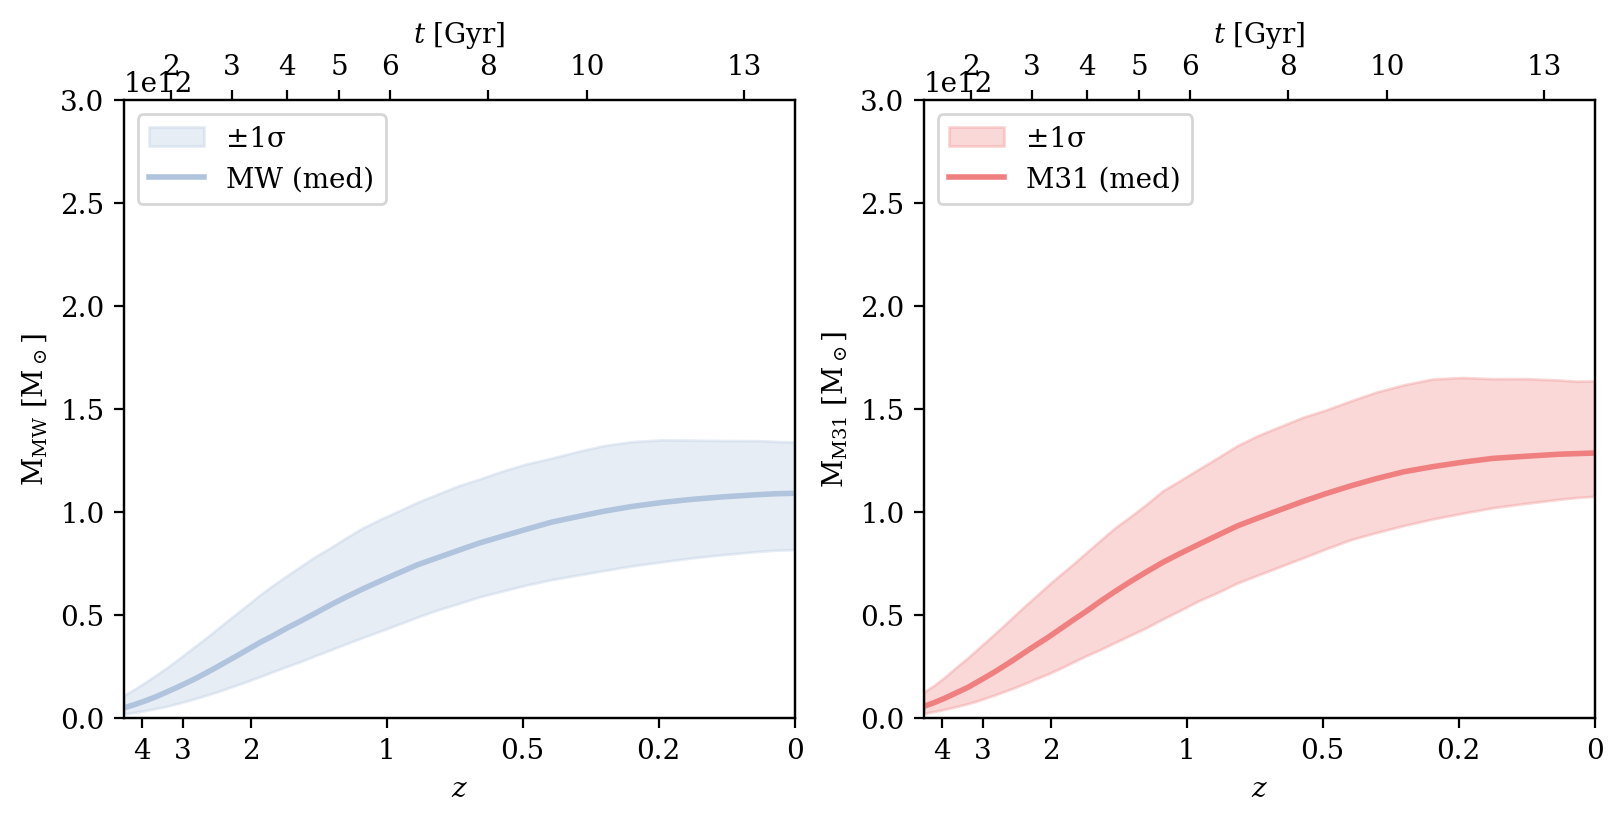

In [32]:
# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1, m_MW_plus1, color='lightsteelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med, color='lightsteelblue', lw=2, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1, m_M31_plus1, color='lightcoral', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med, color='lightcoral', lw=2, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 3e12)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 3e12)

axes[0].set_ylabel(r'$\mathrm{M_{MW} \ [M_\odot]}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31} \ [M_\odot]}$')

# Save plot
plt.savefig('MW_M31_NO_LG_2_plots_evolution_mass.png')
plt.show()

### Same plot normalised

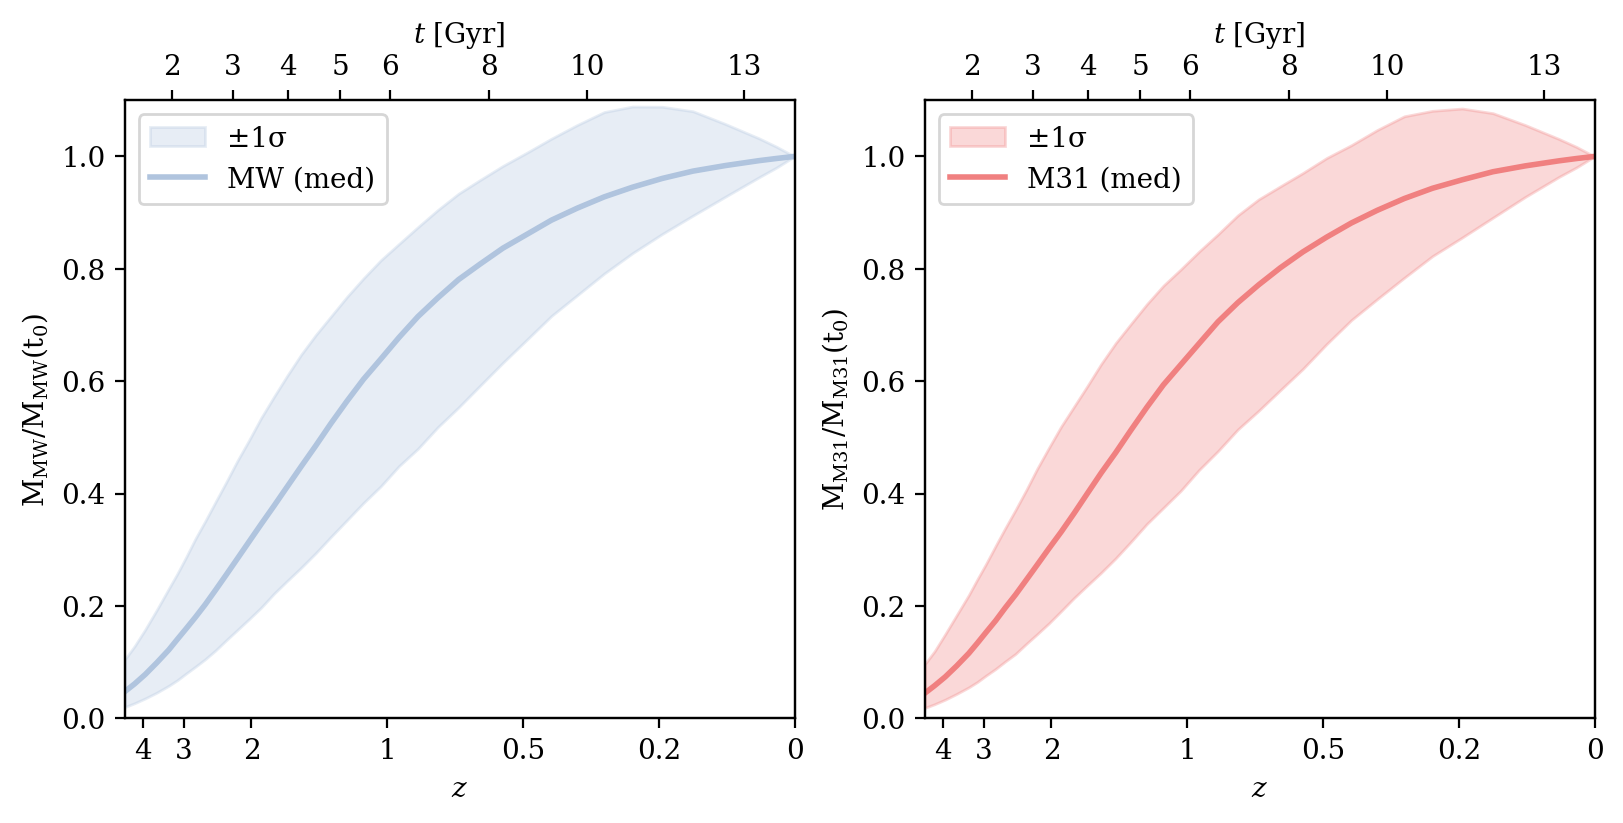

In [33]:
# Ploting

fig, axes = plt.subplots(figsize=(8,4), ncols=2, nrows=1, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0]
ax_MW.fill_between(scale[fine_index], m_MW_minus1_norm, m_MW_plus1_norm, color='lightsteelblue', alpha=0.3, label='±1σ')
ax_MW.plot(scale[fine_index], m_MW_med_norm, color='lightsteelblue', lw=2, label='MW (med)')
ax_MW.legend(loc='upper left')

ax_M31 = axes[1]
ax_M31.fill_between(scale[fine_index], m_M31_minus1_norm, m_M31_plus1_norm, color='lightcoral', alpha=0.3, label='±1σ')
ax_M31.plot(scale[fine_index], m_M31_med_norm, color='lightcoral', lw=2, label='M31 (med)')
ax_M31.legend(loc='upper left')

# Axes

for ax in axes:

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_xlim(min(scale[fine_index]), 1)
    ax.set_ylim(0, 1.1)
    ax2.set_xlim(min(scale[fine_index]), 1)
    ax2.set_ylim(0, 1.1)

axes[0].set_ylabel(r'$\mathrm{M_{MW}/M_{MW}(t_0)}$')
axes[1].set_ylabel(r'$\mathrm{M_{M31}/M_{M31}(t_0)}$')



# Save plot
plt.savefig('MW_M31_NO_LG_2_plots_normalised_evolution_mass.png')
plt.show()

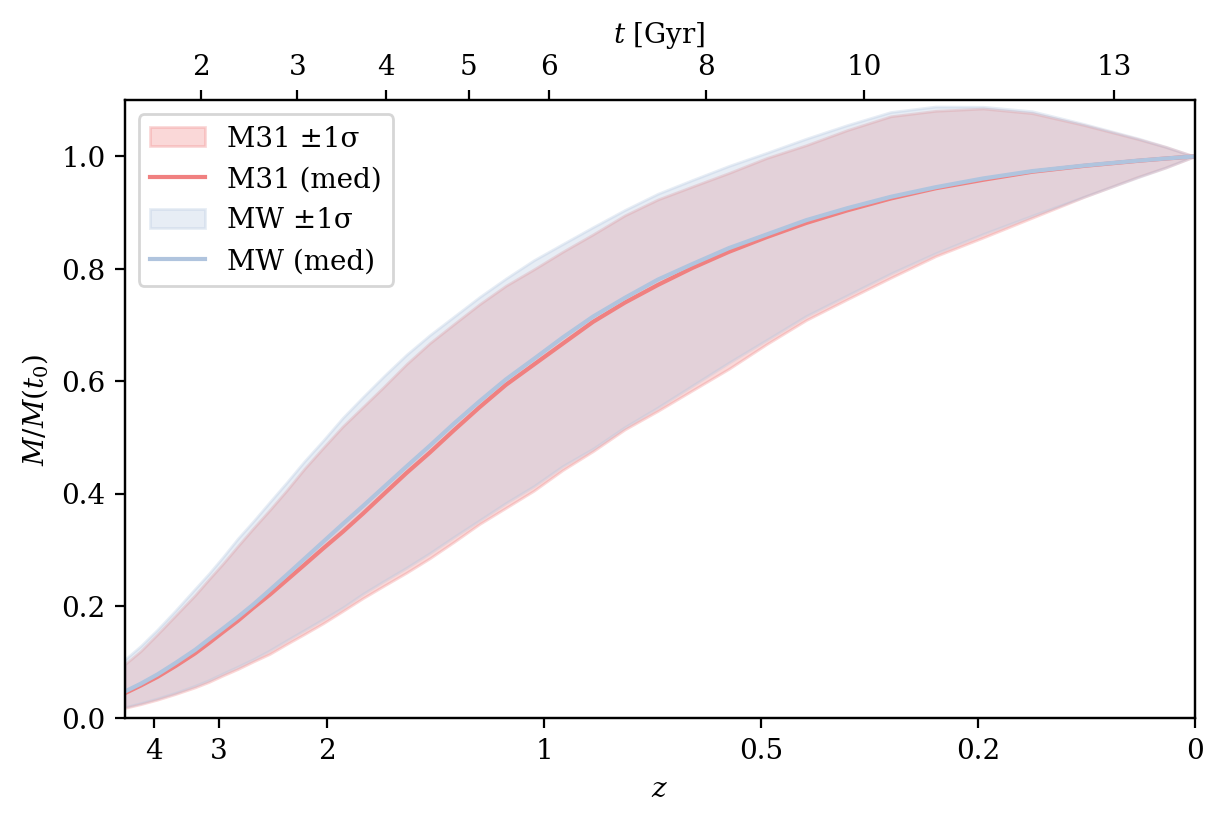

In [34]:
#------------
# Ploting
#------------

fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

ax.fill_between(scale[fine_index],
                m_M31_minus1_norm, m_M31_plus1_norm,
                color='lightcoral', alpha=0.3,
                label='M31 ±1σ')
ax.plot(scale[fine_index],
        m_M31_med_norm,
        color='lightcoral', lw=1.5,
        label='M31 (med)')

ax.fill_between(scale[fine_index],
                m_MW_minus1_norm, m_MW_plus1_norm,
                color='lightsteelblue', alpha=0.3,
                label='MW ±1σ')
ax.plot(scale[fine_index],
        m_MW_med_norm,
        color='lightsteelblue', lw=1.5,
        label='MW (med)')

#------------
# Axes
#------------

# Redshift
ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

# Time in Gyr
ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)

# Normalised mass
ax.set_ylim(0, 1.1)
ax.set_ylabel(r'$M/M(t_0)$')

# Legend
ax.legend(loc='upper left')

# ---------------
# Save and show
# ---------------
plt.savefig('MW_M31_NO_LG_superposed_normalised_evolution_mass.png')
plt.show()


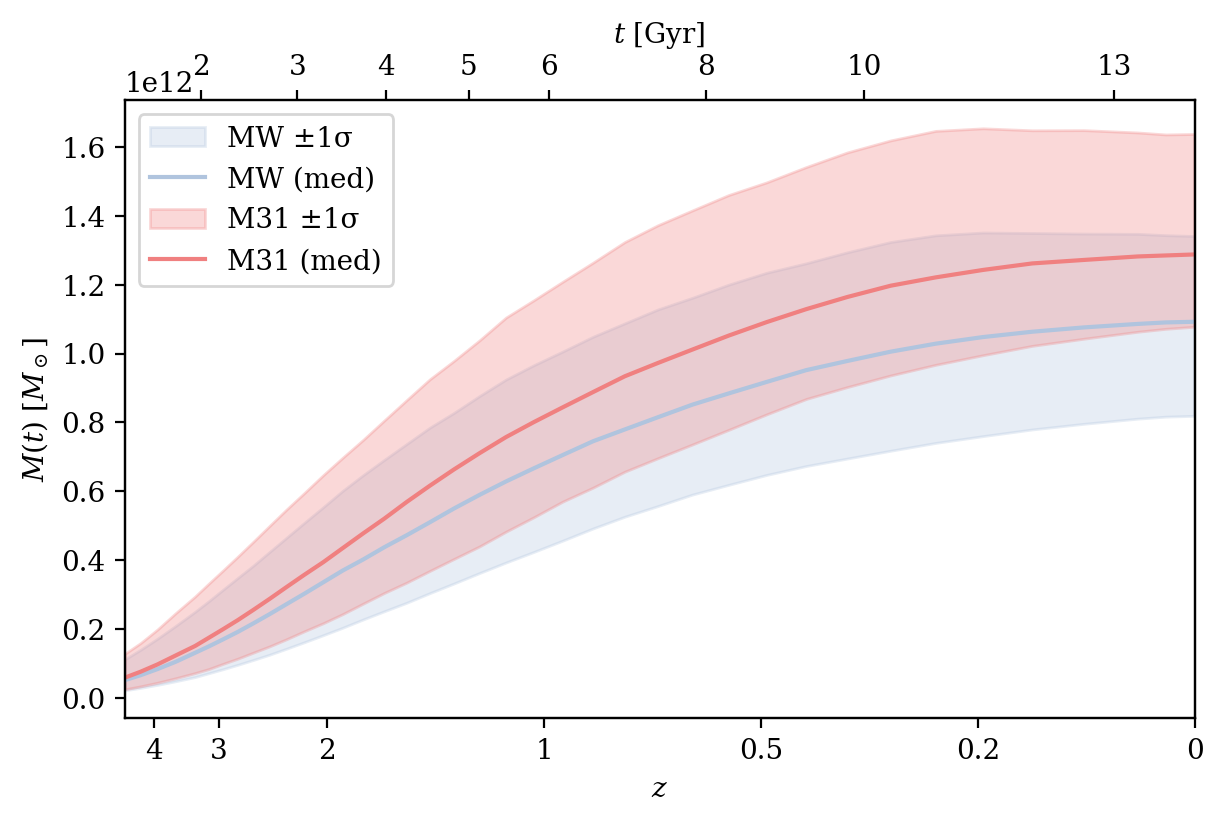

In [35]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200, constrained_layout=True)

# Tracé pour MW
ax.fill_between(scale[fine_index],
                m_MW_minus1, m_MW_plus1,
                color='lightsteelblue', alpha=0.3,
                label='MW ±1σ')
ax.plot(scale[fine_index],
        m_MW_med,
        color='lightsteelblue', lw=1.5,
        label='MW (med)')

# Tracé pour M31
ax.fill_between(scale[fine_index],
                m_M31_minus1, m_M31_plus1,
                color='lightcoral', alpha=0.3,
                label='M31 ±1σ')
ax.plot(scale[fine_index],
        m_M31_med,
        color='lightcoral', lw=1.5,
        label='M31 (med)')

ax.set_xticks(label_scales)
ax.set_xticklabels(label_redshifts_str)
ax.set_xlabel(r'$z$')
ax.set_xlim(min(scale[fine_index]), 1)

ax.set_ylabel(r'$M(t)\ [M_\odot]$')

ax2 = ax.twiny()
ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
ax2.set_xticks(ageticks)
ax2.set_xticklabels([f'{age:g}' for age in ages.value])
ax2.set_xlim(min(scale[fine_index]), 1)


ax.legend(loc='upper left')
plt.savefig('MW_M31_NO_LG_superposed_evolution_mass.png')
plt.show()
